In [1]:
# Importing required libraries
import os
import cv2
import shutil
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import ticker
from sklearn import metrics
import time
import copy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from torchvision import transforms as T # for simplifying the transforms
import torchvision.datasets as datasets
import keras
import tensorflow as tf
from keras import layers
from keras import regularizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from numpy import expand_dims
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import AdamW
from PIL import Image, ImageEnhance
from pathlib import Path
from matplotlib import pyplot 
from torch.utils.data import DataLoader
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from IPython.display import clear_output
!pip install imutils
# !pip install plotly
clear_output()

# remove warnings
import warnings
warnings.filterwarnings("ignore")

import imutils
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [2]:
# Importing the path to dataset
data_dir = Path("/kaggle/input/brain-tumor/Brain Tumor MRI")

In [3]:
# Total image count inside the dataset
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

7023


In [4]:
# Iterate over subfolders
for subfolder in data_dir.glob('*'):
    if subfolder.is_dir():  # Check if it's a subfolder
        subfolder_name = subfolder.name
        image_count = 0  # Initialize image count for this subfolder
        # Iterate over class folders within the subfolder
        for class_folder in subfolder.glob('*'):
            if class_folder.is_dir():  # Check if it's a class folder
                # Count images in the class folder
                image_count += len(list(class_folder.glob('*.jpg')))
        print(f"Subfolder: {subfolder_name}, Image Count: {image_count}")


Subfolder: Training, Image Count: 5712
Subfolder: Testing, Image Count: 1311


In [5]:
# Define the image size you want
IMG_SIZE = (384, 384)

NUM_CLASSES = 4

# List of subfolders (classes) in the dataset directory
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [3]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [6]:
TRAIN_DIR = '/kaggle/input/brain-tumor/Brain Tumor MRI/Training/'
TEST_DIR = '/kaggle/input/brain-tumor/Brain Tumor MRI/Testing/'

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)

100%|██████████| 4/4 [00:54<00:00, 13.74s/it]


5712 images loaded from /kaggle/input/brain-tumor/Brain Tumor MRI/Training/ directory.


100%|██████████| 4/4 [00:14<00:00,  3.71s/it]

1311 images loaded from /kaggle/input/brain-tumor/Brain Tumor MRI/Testing/ directory.


In [8]:
# Print the shapes
print("X_Train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_Train Shape: (5712, 384, 384, 3)
y_train Shape: (5712,)
X_test Shape: (1311, 384, 384, 3)
y_test Shape: (1311,)


In [9]:
# Check the data type of the training images
print(f"Data type of MRI images (X_train): {X_train.dtype}")
print(f"Min pixel value: {np.min(X_train)}")
print(f"Max pixel value: {np.max(X_train)}")

Data type of MRI images (X_train): uint8
Min pixel value: 0
Max pixel value: 255


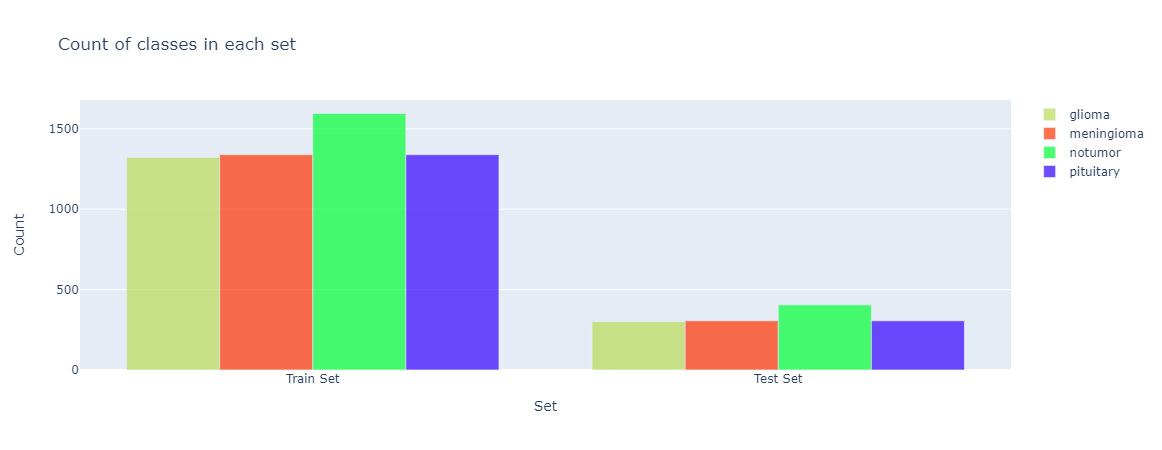

In [10]:
y = dict()
y[0] = []
y[1] = []
y[2] = []
y[3] = []
for set_name in (y_train, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[0],
    name='glioma',
    marker=dict(color='#bada55'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[1],
    name='meningioma',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[2],
    name='notumor',
    marker=dict(color='#00ff33'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[1],
    name='pituitary',
    marker=dict(color='#3300ff'),
    opacity=0.7
)
data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


<h3>Notumour class have more number of samples resulting into a inbalance dataset.</h3>
So, We need to balance the training dataset and keep the testing natural.

In [11]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,2))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

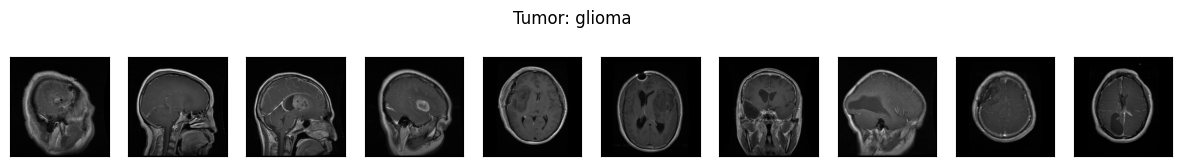

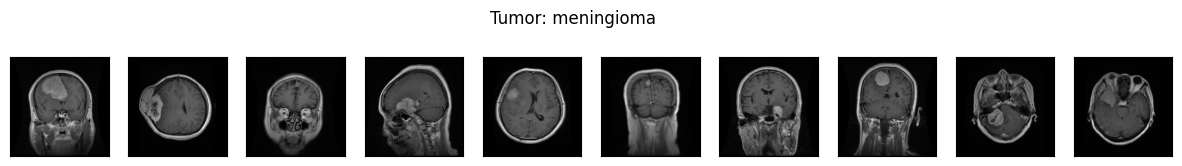

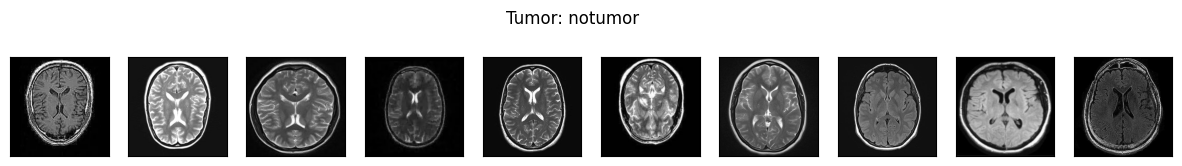

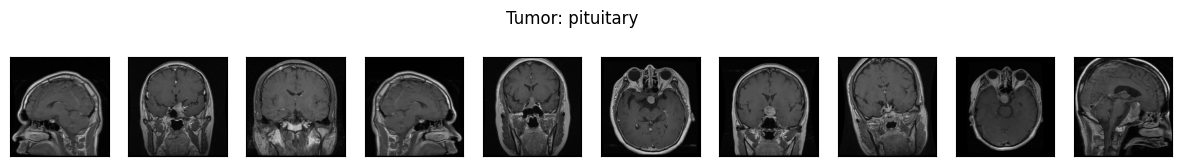

In [12]:
plot_samples(X_train, y_train, labels, 10)

<h3>As we can see, images have different width and height and diffent size of "black corners". Since, we are going to take the image size of (384,384) for the first input layer so some wide images may look weird after resizing.</h3>

**The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.**

In [13]:
def crop_imgs(set_name, add_pixels_value=0, target_shape=(100, 100)):
    """
    Finds the extreme points on the image, crops, and resizes images to a target shape
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        cropped_img = img[extTop[1] - ADD_PIXELS:extBot[1] + ADD_PIXELS, extLeft[0] - ADD_PIXELS:extRight[0] + ADD_PIXELS]
        resized_img = cv2.resize(cropped_img, target_shape)
        set_new.append(resized_img)

    return np.array(set_new)


**Let's look at example what this function will do with MRI scans:**

In [ ]:
# One random sample image path
img = cv2.imread('/kaggle/input/brain-tumor/Brain Tumor MRI/Training/meningioma/Tr-me_0016.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

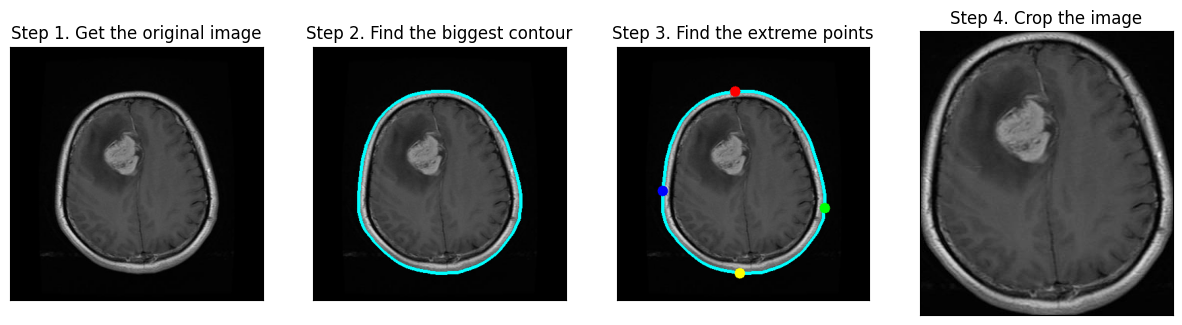

In [16]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [17]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train, target_shape=(384, 384))
X_test_crop = crop_imgs(set_name=X_test, target_shape=(384, 384))

In [18]:
# Print the shapes
print("X_train_crop images Shape:", X_train_crop.shape)

# Check the data type of the X_train_crop images
print(f"Data type of MRI images (X_train_crop): {X_train_crop.dtype}")
print(f"Min pixel value: {np.min(X_train_crop)}")
print(f"Max pixel value: {np.max(X_train_crop)}")

X_train_crop images Shape: (5712, 384, 384, 3)
Data type of MRI images (X_train_crop): uint8
Min pixel value: 0
Max pixel value: 255


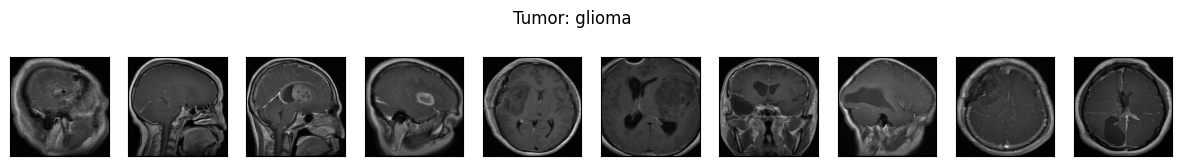

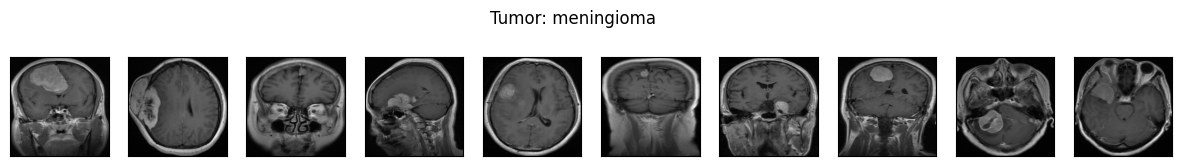

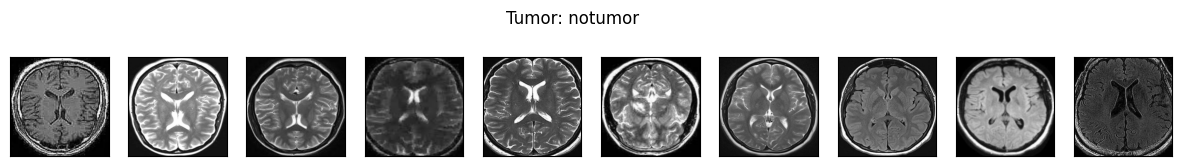

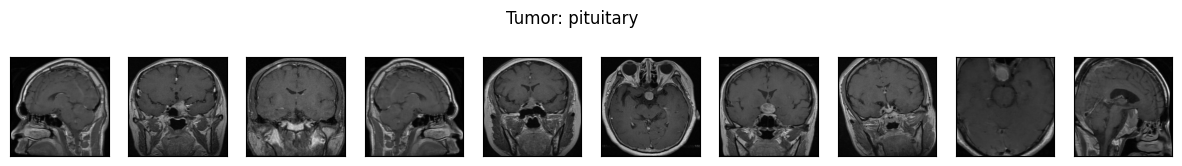

In [19]:
plot_samples(X_train_crop, y_train, labels, 10)

In [20]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for (img, imclass) in zip(x_set, y_set):
        class_name = class_names[imclass]
        cv2.imwrite(f'{folder_name}{class_name}/{class_name}_{i}.png', img)
        i += 1

In [21]:
# Create directories for each class
!mkdir TRAIN_CROP TEST_CROP TRAIN_CROP/glioma TRAIN_CROP/meningioma TRAIN_CROP/notumor TRAIN_CROP/pituitary TEST_CROP/glioma TEST_CROP/meningioma TEST_CROP/notumor TEST_CROP/pituitary
!tree -d

.
|-- TEST_CROP
|   |-- glioma
|   |-- meningioma
|   |-- notumor
|   `-- pituitary
`-- TRAIN_CROP
    |-- glioma
    |-- meningioma
    |-- notumor
    `-- pituitary

10 directories


In [22]:
# Save new images to the folder
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

**2nd Step will be Balancing the training dataset using SMOTE**

In [5]:
Cropped_Img_Dir = "TRAIN_CROP/"

# Initialize empty lists to store images and labels
X = []  # This will store image data
y = []  # This will store corresponding labels

In [6]:
# All subfolders are appended to achieve a more balanced dataset
for subfolder in os.listdir(Cropped_Img_Dir):
    if os.path.isdir(os.path.join(Cropped_Img_Dir, subfolder)):
        label = subfolder
        subfolder_path = os.path.join(Cropped_Img_Dir, subfolder)

        # Iterate through images in the subfolder
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            try:
                # Load the image and append it to X
                image = Image.open(image_path)
                X.append(np.array(image))  # Convert image to numpy array

                # Append the label to y
                y.append(label)
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {str(e)}")

print("Total images loaded:", len(X))
print("Total labels loaded:", len(y))

Total images loaded: 5712
Total labels loaded: 5712


In [7]:
# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

In [8]:
# Reshape each image to a flat 1D array
X_flat = [image.flatten() for image in X]
# Convert the list of flat arrays to a 2D NumPy array
X_flat = np.array(X_flat)

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_flat, y)

# Reshape the flattened images back to their original shape
X_balanced = X_resampled.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)

In [27]:
# Assuming you have a list of class labels, e.g., ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = set(y_resampled)  # Assuming 'y_resampled' contains your class labels

# Iterate through each class label and count images
for label in class_labels:
    image_count = sum(1 for item in y_resampled if item == label)
    print(f'Training Folder: {label}, Image Count: {image_count}')

Training Folder: notumor, Image Count: 1595
Training Folder: pituitary, Image Count: 1595
Training Folder: glioma, Image Count: 1595
Training Folder: meningioma, Image Count: 1595


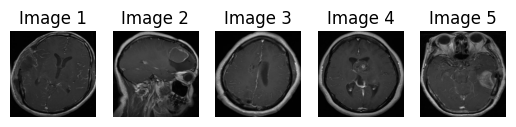

Data type of balanced images (X_balanced): uint8
Min pixel value: 0
Max pixel value: 255


In [28]:
# Assuming X_balanced contains images after balancing
# Plot a few balanced images to check color correctness and data type
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(X_balanced[i])  # Display the image
    plt.title(f"Image {i + 1}")
    plt.axis("off")
plt.show()

# Check the data type of the balanced images
print(f"Data type of balanced images (X_balanced): {X_balanced.dtype}")
print(f"Min pixel value: {np.min(X_balanced)}")
print(f"Max pixel value: {np.max(X_balanced)}")


In [29]:
def save_img(images, labels, classes, save_dir):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    for idx, (img, label) in enumerate(zip(images, labels)):
        class_dir = save_dir / classes[label]
        class_dir.mkdir(parents=True, exist_ok=True)
        img_path = class_dir / f"image_{idx + 1}.png"
        cv2.imwrite(str(img_path), img)
    print(f"Images saved to {save_dir}")

In [30]:
# Map class names to numeric labels
label_mapping = {class_name: idx for idx, class_name in enumerate(classes)}

# Convert y_resampled to numeric labels using the mapping
y_resampled_numeric = [label_mapping[label] for label in y_resampled]

# Save the Balanced images
save_img(X_balanced, y_resampled_numeric, classes, "/kaggle/working/Balanced_MRI_Images")

Images saved to /kaggle/working/Balanced_MRI_Images


In [31]:
# Check the shape of balanced dataset
print("X_balanced Shape:", X_balanced.shape)
print("y_resampled_numeric Shape:", y_resampled.shape)

X_balanced Shape: (6380, 384, 384, 3)
y_resampled_numeric Shape: (6380,)


**A balanced datasets with cropped ROI(reason of intrest) is achieved.**

*Now we will apply augumentation to increse the samples and Before that we explore tha parameters with a demo image.*

In [32]:
os.makedirs('preview', exist_ok=True)
x = X_balanced[0]  
x = x.reshape((1,) + x.shape) 

# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='png'):
    i += 1
    if i > 20:
        break 

In [ ]:
plt.imshow(X_balanced[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
from collections import Counter

# Assuming 'y_resampled' contains your class labels after SMOTE
print("Unique labels in y_resampled:", np.unique(y_resampled))
print("Class distribution in y_resampled:", Counter(y_resampled))

# Augumentation

In [9]:
# Define the class images
glioma_images = X_balanced[y_resampled == 'glioma']
meningioma_images = X_balanced[y_resampled == 'meningioma']
notumor_images = X_balanced[y_resampled == 'notumor']
pituitary_images = X_balanced[y_resampled == 'pituitary']

# Define augmentation factors
glioma_augmentation_factor = 4
meningioma_augmentation_factor = 4
notumor_augmentation_factor = 4
pituitary_augmentation_factor = 4

In [34]:
# Print the shape of the class images
print("Shape of glioma_images", glioma_images.shape)
print("Shape of meningioma_images", meningioma_images.shape)
print("Shape of notumor_images", notumor_images.shape)
print("Shape of pituitary_images", pituitary_images.shape)

Shape of glioma_images (1595, 384, 384, 3)
Shape of meningioma_images (1595, 384, 384, 3)
Shape of notumor_images (1595, 384, 384, 3)
Shape of pituitary_images (1595, 384, 384, 3)


In [10]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,              # Rotate by up to 15 degrees
    width_shift_range=0.15,         # Scale by 15% horizontally
    height_shift_range=0.15,        # Scale by 15% vertically
    horizontal_flip=True,           # Perform horizontal flipping
    vertical_flip=True,             # Perform vertical flipping
    fill_mode='nearest',
    preprocessing_function=lambda x: x + np.random.normal(0, 0.25, x.shape)  # Add Gaussian noise with mean=0 and variance=0.25
)

In [11]:
# Function to apply augmentation, resize, and save images
def aug_images(image_list, label, augmentation_factor, label_name):
    all_images = []
    all_labels = []

    for image in image_list:
        all_images.append(image)
        all_labels.append(label)

    # Generate augmented images on-the-fly
    augmented_data = datagen.flow(np.array(all_images), np.array(all_labels), batch_size=len(all_images), shuffle=False)
    # Get augmented images and labels
    X_augmented, y_augmented = next(augmented_data)
    # Save augmented images
    augmented_path = f"Augmented/Augmented_{label_name}"
    os.makedirs(augmented_path, exist_ok=True)

    for i in range(len(all_images)):
        for j in range(augmentation_factor):
            index = i * augmentation_factor + j
            cv2.imwrite(os.path.join(augmented_path, f'aug_{index+1}.png'), X_augmented[index % len(X_augmented)])

In [12]:
# Process glioma Images
aug_images(glioma_images, 0, glioma_augmentation_factor, 'Glioma')

# Process meningioma Images
aug_images(meningioma_images, 1, meningioma_augmentation_factor, 'Meningioma')

# Process notumor Images
aug_images(notumor_images, 2, notumor_augmentation_factor, 'Notumor')

# Process pituitary Images
aug_images(pituitary_images, 3, pituitary_augmentation_factor, 'Pituitary')

print("Augmentation completed successfully.")

Augmentation completed successfully.


In [14]:
augmented_dir = Path("/kaggle/working/Augmented")

# Iterate over subfolders and count images in each subfolder
for subfolder in augmented_dir.glob('*'):
    if subfolder.is_dir():  # checks if it's a subfolder
        subfolder_name = subfolder.name
        image_count = len(list(subfolder.glob('*.png')))
        print(f"Folder: {subfolder_name}, Image Count: {image_count}")

Folder: Augmented_Pituitary, Image Count: 6380
Folder: Augmented_Glioma, Image Count: 6380
Folder: Augmented_Meningioma, Image Count: 6380
Folder: Augmented_Notumor, Image Count: 6380


In [7]:
TRAINING_DIR = '/kaggle/working/Augmented/'

# use predefined function to load the image data into workspace
X_training, y_training, labels = load_data(TRAINING_DIR, IMG_SIZE)

100%|██████████| 4/4 [02:12<00:00, 33.17s/it]


25520 images loaded from /kaggle/working/Augmented/ directory.


In [ ]:
plot_samples(X_training, y_training, labels, 10)

In [ ]:
# Check the shapes of the training  sets
print("X_training shape:", X_training.shape)
print("y_training shape:", y_training.shape)

In [ ]:
# Check the data type of the preprocessed_augmented images
print(f"Data type of HP images (X_training): {X_training.dtype}")
print(f"Min pixel value: {np.min(X_training)}")
print(f"Max pixel value: {np.max(X_training)}")

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the percentages for training and validation sets
TRAIN_PERCENT = 0.7  # 70% for training
VAL_PERCENT = 0.3    # 30% for validation

# Initialize StratifiedShuffleSplit
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=VAL_PERCENT, random_state=42)

# Perform stratified splitting
for train_index, val_index in stratified_splitter.split(X_training, y_training):
    X_Train, y_Train = X_training[train_index], y_training[train_index]
    X_val, y_val = X_training[val_index], y_training[val_index]

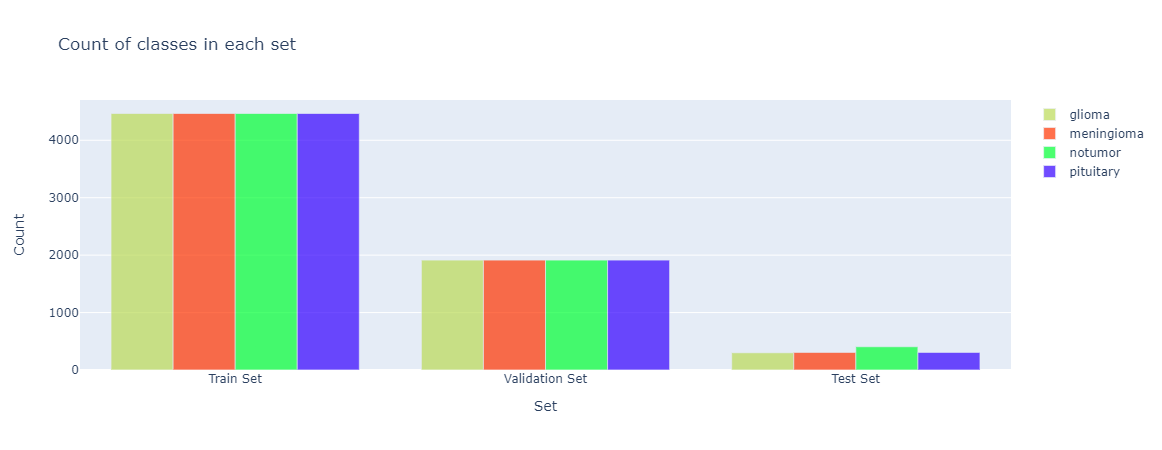

In [9]:
y = dict()
y[0] = []
y[1] = []
y[2] = []
y[3] = []
for set_name in (y_Train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='glioma',
    marker=dict(color='#bada55'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='meningioma',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[2],
    name='notumor',
    marker=dict(color='#00ff33'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='pituitary',
    marker=dict(color='#3300ff'),
    opacity=0.7
)
data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


In [ ]:
# Check the shapes of the training and validation sets
print("X_Train shape:", X_Train.shape)
print("y_Train shape:", y_Train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

In [ ]:
# Check the data type of the X_Train images
print(f"Data type of HP images (X_Train): {X_Train.dtype}")
print(f"Min pixel value: {np.min(X_Train)}")
print(f"Max pixel value: {np.max(X_Train)}")

In [10]:
# Create the directories if they don't exist
os.makedirs('Training_Dir', exist_ok=True)
os.makedirs('Validation_Dir', exist_ok=True)

# Use predefined function to load the image data into workspace
# Load resized images as np.arrays to the workspace
def save_images(directory, X, y, img_size=(100, 100)):
    """
    Save resized images as np.arrays to the specified directory
    """
    for i in tqdm(range(len(X))):
        label = labels[y[i]]
        img_name = f"{label}_{i}.png"
        img_path = os.path.join(directory, label, img_name)
        os.makedirs(os.path.dirname(img_path), exist_ok=True)
        img = cv2.resize(X[i], img_size)
        cv2.imwrite(img_path, img)

# Save training images
save_images('Training_Dir', X_Train, y_Train, IMG_SIZE)

# Save validation images
save_images('Validation_Dir', X_val, y_val, IMG_SIZE)

print("Balanced images saved successfully.")

100%|██████████| 7656/7656 [01:12<00:00, 105.85it/s]

Balanced images saved successfully.


In [11]:
# Define your directories and other constants
TRAINING_DIR = '/kaggle/working/Training_Dir/'
VALIDATION_DIR = '/kaggle/working/Validation_Dir/'
TEST_DIR = '/kaggle/working/TEST_CROP/'

# Define your data transformations and generators
train_transforms = T.Compose([
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
])

test_transforms = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = datasets.ImageFolder(TRAINING_DIR, transform=train_transforms)
validation_dataset = datasets.ImageFolder(VALIDATION_DIR, transform=test_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

dataloaders = {'train': train_loader, 'val': validation_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(validation_dataset)}


In [12]:
!pip install timm --quiet
import timm

# Load DeIT model
DeIT_model = timm.create_model('deit_base_patch16_384', pretrained=True)

# Unfreeze the last few layers for fine-tuning
num_unfrozen_layers = 32
for param in DeIT_model.parameters():
    param.requires_grad = False
    
#freezing model
for param in DeIT_model.blocks[-num_unfrozen_layers:].parameters():
    param.requires_grad = True

n_inputs = DeIT_model.head.in_features
DeIT_model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, NUM_CLASSES),
)

print(DeIT_model.head)

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=4, bias=True)
)


In [ ]:
!pip install torchinfo --quiet
from torchinfo import summary

summary(DeIT_model,input_size=(1,3,384,384))

In [13]:
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

# Set device and other training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = AdamW(DeIT_model.head.parameters(), lr=0.0001, weight_decay=0.01)
# lr scheduler
reduce_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [15]:
# Define your train_model function
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print("-"*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step(running_corrects)  # Pass training accuracy as the metric for ReduceLROnPlateau

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().numpy())  # Convert accuracy to numpy array
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().numpy())  # Convert accuracy to numpy array

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/30
----------


100%|██████████| 280/280 [10:51<00:00,  2.33s/it]


train Loss: 0.6605 Acc: 0.8532


100%|██████████| 240/240 [03:15<00:00,  1.23it/s]


val Loss: 0.5712 Acc: 0.8945

Epoch 2/30
----------


100%|██████████| 280/280 [10:40<00:00,  2.29s/it]


train Loss: 0.5862 Acc: 0.8922


100%|██████████| 240/240 [03:11<00:00,  1.25it/s]


val Loss: 0.5385 Acc: 0.9152

Epoch 3/30
----------


100%|██████████| 280/280 [10:40<00:00,  2.29s/it]


train Loss: 0.5489 Acc: 0.9129


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.5171 Acc: 0.9242

Epoch 4/30
----------


100%|██████████| 280/280 [10:38<00:00,  2.28s/it]


train Loss: 0.5308 Acc: 0.9235


100%|██████████| 240/240 [03:12<00:00,  1.25it/s]


val Loss: 0.5029 Acc: 0.9347

Epoch 5/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.5142 Acc: 0.9348


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4827 Acc: 0.9427

Epoch 6/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4988 Acc: 0.9427


100%|██████████| 240/240 [03:11<00:00,  1.25it/s]


val Loss: 0.4753 Acc: 0.9479

Epoch 7/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4879 Acc: 0.9490


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4620 Acc: 0.9557

Epoch 8/30
----------


100%|██████████| 280/280 [10:39<00:00,  2.28s/it]


train Loss: 0.4818 Acc: 0.9523


100%|██████████| 240/240 [03:11<00:00,  1.25it/s]


val Loss: 0.4667 Acc: 0.9552

Epoch 9/30
----------


100%|██████████| 280/280 [10:38<00:00,  2.28s/it]


train Loss: 0.4746 Acc: 0.9564


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4510 Acc: 0.9653

Epoch 10/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4651 Acc: 0.9630


100%|██████████| 240/240 [03:11<00:00,  1.25it/s]


val Loss: 0.4477 Acc: 0.9663

Epoch 11/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4589 Acc: 0.9656


100%|██████████| 240/240 [03:11<00:00,  1.25it/s]


val Loss: 0.4365 Acc: 0.9715

Epoch 12/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4552 Acc: 0.9675


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4397 Acc: 0.9740

Epoch 13/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4499 Acc: 0.9689


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4332 Acc: 0.9748

Epoch 14/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4485 Acc: 0.9702


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4421 Acc: 0.9705

Epoch 15/30
----------


100%|██████████| 280/280 [10:38<00:00,  2.28s/it]


train Loss: 0.4456 Acc: 0.9713


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4240 Acc: 0.9775

Epoch 16/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4425 Acc: 0.9743


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4286 Acc: 0.9760

Epoch 17/30
----------


100%|██████████| 280/280 [10:35<00:00,  2.27s/it]


train Loss: 0.4371 Acc: 0.9785


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4252 Acc: 0.9771

Epoch 18/30
----------


100%|██████████| 280/280 [10:35<00:00,  2.27s/it]


train Loss: 0.4347 Acc: 0.9790


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4164 Acc: 0.9792

Epoch 19/30
----------


100%|██████████| 280/280 [10:35<00:00,  2.27s/it]


train Loss: 0.4339 Acc: 0.9774


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4197 Acc: 0.9801

Epoch 20/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4275 Acc: 0.9811


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4091 Acc: 0.9868

Epoch 21/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4272 Acc: 0.9818


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4146 Acc: 0.9817

Epoch 22/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4256 Acc: 0.9816


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4086 Acc: 0.9875

Epoch 23/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4239 Acc: 0.9819


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4032 Acc: 0.9886

Epoch 24/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4218 Acc: 0.9839


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.4021 Acc: 0.9906

Epoch 25/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4202 Acc: 0.9848


100%|██████████| 240/240 [03:11<00:00,  1.25it/s]


val Loss: 0.4115 Acc: 0.9843

Epoch 26/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4165 Acc: 0.9867


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4017 Acc: 0.9901

Epoch 27/30
----------


100%|██████████| 280/280 [10:38<00:00,  2.28s/it]


train Loss: 0.4159 Acc: 0.9856


100%|██████████| 240/240 [03:10<00:00,  1.26it/s]


val Loss: 0.3995 Acc: 0.9911

Epoch 28/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4148 Acc: 0.9873


100%|██████████| 240/240 [03:11<00:00,  1.25it/s]


val Loss: 0.3963 Acc: 0.9914

Epoch 29/30
----------


100%|██████████| 280/280 [10:36<00:00,  2.27s/it]


train Loss: 0.4127 Acc: 0.9880


100%|██████████| 240/240 [03:11<00:00,  1.26it/s]


val Loss: 0.4018 Acc: 0.9899

Epoch 30/30
----------


100%|██████████| 280/280 [10:37<00:00,  2.28s/it]


train Loss: 0.4132 Acc: 0.9868


100%|██████████| 240/240 [03:11<00:00,  1.25it/s]


val Loss: 0.3976 Acc: 0.9896

Training complete in 414m 38s
Best Val Acc: 0.9914


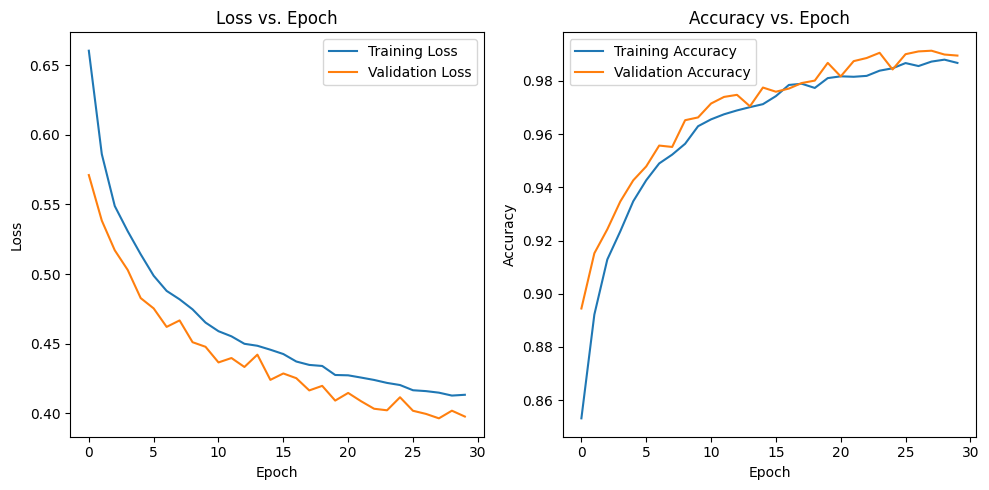

In [9]:
# Now, call your train_model function with the defined parameters including early stopping based on custom criteria
model_ft = train_model(DeIT_model, criterion, optimizer, reduce_lr_scheduler)

In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    return cm, report

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       300
           1       0.91      0.94      0.93       306
           2       0.99      1.00      0.99       405
           3       0.98      0.97      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



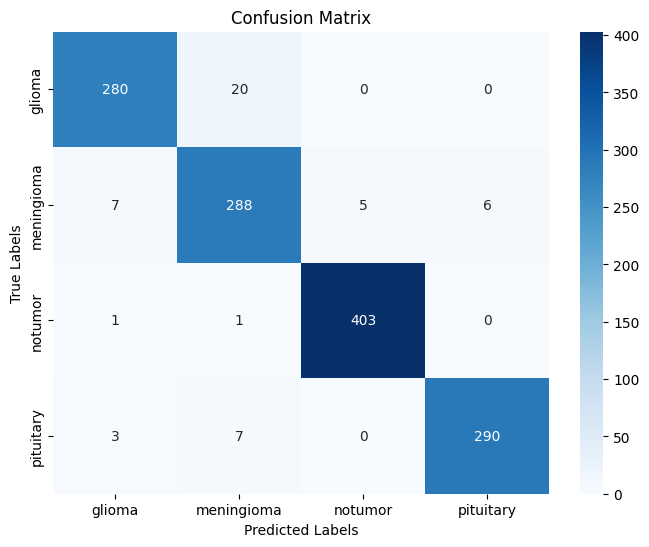

In [11]:
test_cm, test_report = evaluate_model(model_ft, test_loader)
print("Test Classification Report:\n", test_report)
plot_confusion_matrix(test_cm, classes=test_dataset.classes)
